In [1]:
from pmotifs.analysis_utilities.loading import Result
from pmotifs.config import config

GRAPHLET_SIZE = 3

r = Result.load_result(
    config.DATASET_DIRECTORY /  "yeastInter_st.txt",
    config.EXPERIMENT_OUT / "yeastInter_st",
    GRAPHLET_SIZE,
)

g = r.pmotif_graph
df = r.positional_metric_df

Loading graph modules: 100%|████████████████| 27/27 [00:00<00:00, 306900.29it/s]


In [2]:
randomized_results = Result.load_randomized_results(g, GRAPHLET_SIZE, supress_tqdm=True)

Loading Randomized Results: 100%|██████████| 100/100 [00:00<00:00, 24369.90it/s]


In [3]:
randomized_results = {
    r.pmotif_graph: r.positional_metric_df
    for r in randomized_results
}

# Analysis

In [4]:
from pmotifs.graphlet_representation import GRAPHLET_CLASS_NAME_LOOKUP, get_graphlet_size_from_class

def all_graphlet_classes_of_size(graphlet_size: int):
    return [
        graphlet_class
        for graphlet_class in GRAPHLET_CLASS_NAME_LOOKUP.keys()
        if get_graphlet_size_from_class(graphlet_class) == graphlet_size
    ]
all_graphlet_classes_of_size(GRAPHLET_SIZE)

['011 101 110', '011 100 100']

In [5]:
from collections import defaultdict

# Collect frequencies per class
def to_graphlet_class_frequency(result_df):
    graphlet_size = get_graphlet_size_from_class(result_df["graphlet_class"][0])
    all_frequencies = defaultdict.fromkeys(all_graphlet_classes_of_size(graphlet_size), 0)
           
    return dict(all_frequencies | dict(result_df.groupby("graphlet_class").agg("count")["nodes"]))

to_graphlet_class_frequency(df)

{'011 101 110': 72, '011 100 100': 13078}

In [6]:
from tqdm import tqdm
import pandas as pd
# Collect graphlet frequencies per random graph in a df
# random graph num | graphlet class 1 | graphlet class 2
# 1                | 15               | 500
# 2                | 600              | 600
# ...

data = []
for random_df in tqdm(randomized_results.values()):
    data.append(to_graphlet_class_frequency(random_df))
random_frequencies = pd.DataFrame(data)

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 297.57it/s]


In [7]:
from statistics import mean, stdev
from typing import List

def get_zscore(point: float, values: List[float]):
    return (point - mean(values)) / stdev(values)

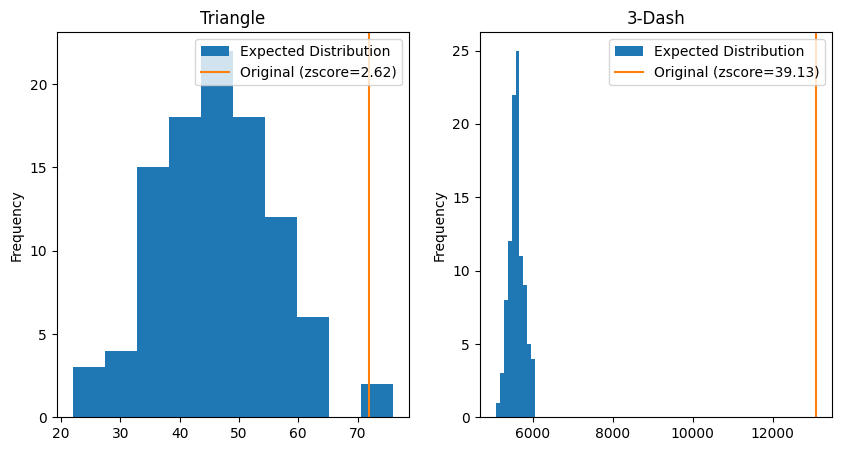

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, len(all_graphlet_classes_of_size(GRAPHLET_SIZE)), figsize=(10,5))

original_frequencies = to_graphlet_class_frequency(df)
    
for i, graphlet_class in enumerate(all_graphlet_classes_of_size(GRAPHLET_SIZE)):
    ax = axes[i]
    
    original_value = original_frequencies[graphlet_class]
    distribution = random_frequencies[graphlet_class]
    z_score = get_zscore(original_value, distribution)
    
    distribution.plot.hist(ax=ax, label="Expected Distribution")
    
    ax.axvline(original_value, color="tab:orange", label=f"Original (zscore={round(z_score, 2)})")
    ax.set_title(GRAPHLET_CLASS_NAME_LOOKUP[graphlet_class])
    ax.legend(loc="upper right")